In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

from neuralbridge.stochastic_processes.examples import (
    LandmarkLagrangianProcess, LandmarkLagrangianAuxProcess
)
from neuralbridge.solvers.sde import WienerProcess, Euler
from neuralbridge.stochastic_processes.conds import GuidedBridgeProcess
from neuralbridge.networks.mlps import MLP, MLPSmall
from neuralbridge.models import neurb, pCN, scorematching
from neuralbridge.utils.plotting import plot_landmark_sample_path

In [3]:
def ellipse(n_landmarks: int, a: float = 1.0, b: float = 1.0, rotation: float = 0.0, shift_x: float = 0.0, shift_y: float = 0.0):
    u = jnp.linspace(0.0, 2.0*jnp.pi, num=n_landmarks, endpoint=False)
    x = a * jnp.sin(u)
    y = b * jnp.cos(u)
    x_rot = x * jnp.cos(rotation) - y * jnp.sin(rotation) 
    y_rot = x * jnp.sin(rotation) + y * jnp.cos(rotation)
    x_shift = x_rot + shift_x
    y_shift = y_rot + shift_y
    u = jnp.stack([x_shift, y_shift], axis=-1)
    return u

INFO:jax._src.xla_bridge:Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/opt/homebrew/Caskroom/miniconda/base/envs/neuralbridge/bin/../lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.so' (no such file), '/usr/local/lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache)


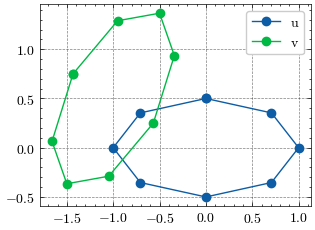

In [4]:
n_landmarks = 8       # number of landmarks
m_landmarks = 2         # number of dimensions per landmark
dim = n_landmarks * m_landmarks

T = 1.0
dt = 1. / 200

seed = 42

u = ellipse(n_landmarks=n_landmarks, a=1.0, b=0.5, rotation=0.0).flatten()
v = ellipse(n_landmarks=n_landmarks, a=1.0, b=0.5, rotation=jnp.pi/3, shift_x=-1.0, shift_y=0.5).flatten()
u_closed = jnp.concatenate([u, u[:2]])  # Add first point to end to close curve
v_closed = jnp.concatenate([v, v[:2]])
plt.plot(*u_closed.reshape(-1, 2).T, "-o", label="u") 
plt.plot(*v_closed.reshape(-1, 2).T, "-o", label="v")
plt.legend()

In [5]:
t_scheme = "linear"
ode_solver_kernel = "dopri5"

params = {
    "k_alpha": 0.3,
    "k_sigma": 0.5,
    "n_landmarks": n_landmarks,
    "m_landmarks": m_landmarks,
}

W = WienerProcess(T=T, dt=dt, shape=(n_landmarks * m_landmarks, ), t_scheme=t_scheme)
X = LandmarkLagrangianProcess(
    params=params,
    T=T,
)
X_tilde = LandmarkLagrangianAuxProcess(
    params=params,
    T=T,
)
X_tilde.init_g(v=v)

X_solver = Euler(X, W)
X_tilde_solver = Euler(X_tilde, W)

In [6]:
X_path = X_solver.solve(x0=u, rng_key=jax.random.PRNGKey(seed), batch_size=16)
X_tilde_path = X_tilde_solver.solve(x0=u, rng_key=jax.random.PRNGKey(seed), batch_size=16)

X_circ = GuidedBridgeProcess(
    X=X,
    X_tilde=X_tilde,
    u=u,
    v=v,
    L0=jnp.eye(dim),
    Sigma0=jnp.eye(dim) * 1e-3,
    ts=jnp.arange(0, T + dt, dt),
    ode_solver_kernel=ode_solver_kernel
)
X_circ_solver = Euler(X_circ, W)

X_circ_path = X_circ_solver.solve(x0=u, rng_key=jax.random.PRNGKey(seed), batch_size=4, enforce_end_point=v)

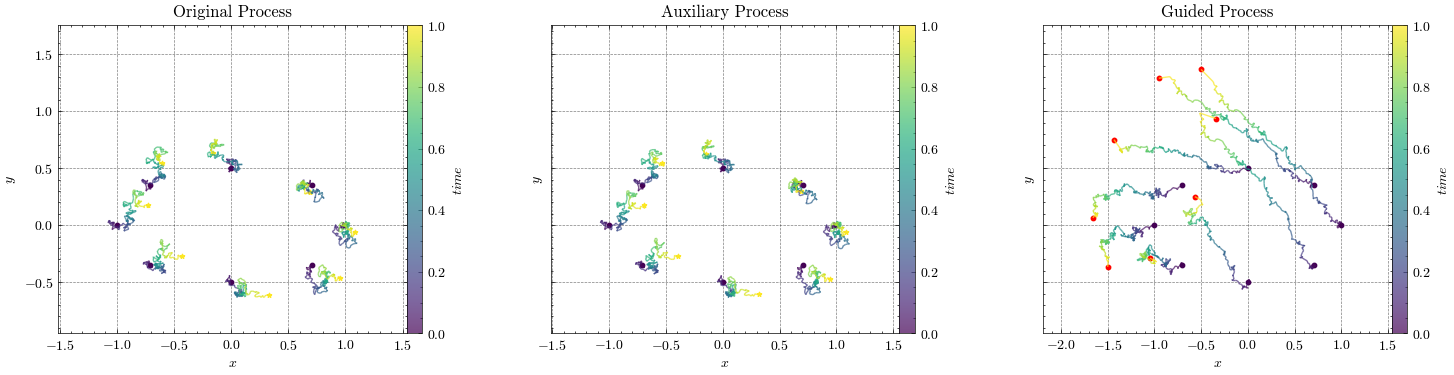

In [7]:
fig, ax = plt.subplots(1, 3, figsize=(18, 4), sharey=True)
plot_landmark_sample_path(X_path[1], m_landmarks, ax=ax[0], cmap="viridis", scatter_size=10, title="Original Process")
plot_landmark_sample_path(X_tilde_path[1], m_landmarks, ax=ax[1], cmap="viridis", scatter_size=10, title="Auxiliary Process")
plot_landmark_sample_path(X_circ_path[1], m_landmarks, ax=ax[2], cmap="viridis", scatter_size=10, title="Guided Process")
ax[2].scatter(v.reshape(-1, 2)[:, 0], v.reshape(-1, 2)[:, 1], s=10, label="v", color='r')


In [8]:
neural_net = MLPSmall(
    out_dim=dim,
    hidden_dims=(32, 64, 64, 32),
)

In [9]:
train_config = {
    "save_name": "landmarks_circle_3e-1alpha_5e-1sigma_new",
    "seed": seed,
    "learning_rate": 5e-4,
    "batch_size": 16,
    "n_iters": 1000,
    "n_epochs": 10,
    "ema_decay": 0.995,
    "optimizer": "adam",
    "clip_norm": None,
    "warmup_steps": 500
}

In [10]:
neural_bridge = neurb.NeuralBridge(
    X_circ=X_circ,
    neural_net=neural_net,
    train_config=train_config
)
neural_bridge.initialize_path_solver(W)

In [11]:
losses = neural_bridge.train(u=u, v=v, mode="train")

Training epochs:   0%|          | 0/10 [00:00<?, ?epoch/s]

Epoch 1:   0%|          | 0/1000 [00:00<?, ?iter/s]

INFO:root:Epoch 1 average loss: -4.17548
INFO:root:Checkpoint saved to /Users/vbd402/Documents/Projects/neuralbridge/assets/ckpts/neuralbridge/landmarks_circle_3e-1alpha_5e-1sigma_new/epoch_1


Epoch 2:   0%|          | 0/1000 [00:00<?, ?iter/s]

INFO:root:Epoch 2 average loss: -9.19869
INFO:root:Checkpoint saved to /Users/vbd402/Documents/Projects/neuralbridge/assets/ckpts/neuralbridge/landmarks_circle_3e-1alpha_5e-1sigma_new/epoch_2


Epoch 3:   0%|          | 0/1000 [00:00<?, ?iter/s]

INFO:root:Epoch 3 average loss: -9.92938
INFO:root:Checkpoint saved to /Users/vbd402/Documents/Projects/neuralbridge/assets/ckpts/neuralbridge/landmarks_circle_3e-1alpha_5e-1sigma_new/epoch_3


Epoch 4:   0%|          | 0/1000 [00:00<?, ?iter/s]

INFO:root:Epoch 4 average loss: -10.29974
INFO:root:Checkpoint saved to /Users/vbd402/Documents/Projects/neuralbridge/assets/ckpts/neuralbridge/landmarks_circle_3e-1alpha_5e-1sigma_new/epoch_4


Epoch 5:   0%|          | 0/1000 [00:00<?, ?iter/s]

INFO:root:Epoch 5 average loss: -11.12652
INFO:root:Checkpoint saved to /Users/vbd402/Documents/Projects/neuralbridge/assets/ckpts/neuralbridge/landmarks_circle_3e-1alpha_5e-1sigma_new/epoch_5


Epoch 6:   0%|          | 0/1000 [00:00<?, ?iter/s]

INFO:root:Epoch 6 average loss: -11.98336
INFO:root:Checkpoint saved to /Users/vbd402/Documents/Projects/neuralbridge/assets/ckpts/neuralbridge/landmarks_circle_3e-1alpha_5e-1sigma_new/epoch_6


Epoch 7:   0%|          | 0/1000 [00:00<?, ?iter/s]

INFO:root:Epoch 7 average loss: -12.42322
INFO:root:Checkpoint saved to /Users/vbd402/Documents/Projects/neuralbridge/assets/ckpts/neuralbridge/landmarks_circle_3e-1alpha_5e-1sigma_new/epoch_7


Epoch 8:   0%|          | 0/1000 [00:00<?, ?iter/s]

INFO:root:Epoch 8 average loss: -12.91916
INFO:root:Checkpoint saved to /Users/vbd402/Documents/Projects/neuralbridge/assets/ckpts/neuralbridge/landmarks_circle_3e-1alpha_5e-1sigma_new/epoch_8


Epoch 9:   0%|          | 0/1000 [00:00<?, ?iter/s]

INFO:root:Epoch 9 average loss: -13.19122
INFO:root:Checkpoint saved to /Users/vbd402/Documents/Projects/neuralbridge/assets/ckpts/neuralbridge/landmarks_circle_3e-1alpha_5e-1sigma_new/epoch_9


Epoch 10:   0%|          | 0/1000 [00:00<?, ?iter/s]

INFO:root:Epoch 10 average loss: -13.23186
INFO:root:Checkpoint saved to /Users/vbd402/Documents/Projects/neuralbridge/assets/ckpts/neuralbridge/landmarks_circle_3e-1alpha_5e-1sigma_new/epoch_10


In [12]:
X_diamond_path = neural_bridge.solve(x0=u, rng_key=jax.random.PRNGKey(seed), batch_size=4)

In [13]:
pCN_config = {
    "seed": seed,
    "rho": 0.9,
    "batch_size": 4,
    "n_iters": 5000
}
pCN_model = pCN.PreconditionedCrankNicolson(guided_bridge=X_circ, run_config=pCN_config)
pCN_model.initialize_path_solver(W)
pCN_result = pCN_model.run_pCN()

Running for 5,000 iterations:   0%|          | 0/5000 [00:00<?, ?it/s]

INFO:root:Batch average acceptance rate: 12.26%


Text(0, 0.5, 'Log-likelihood')

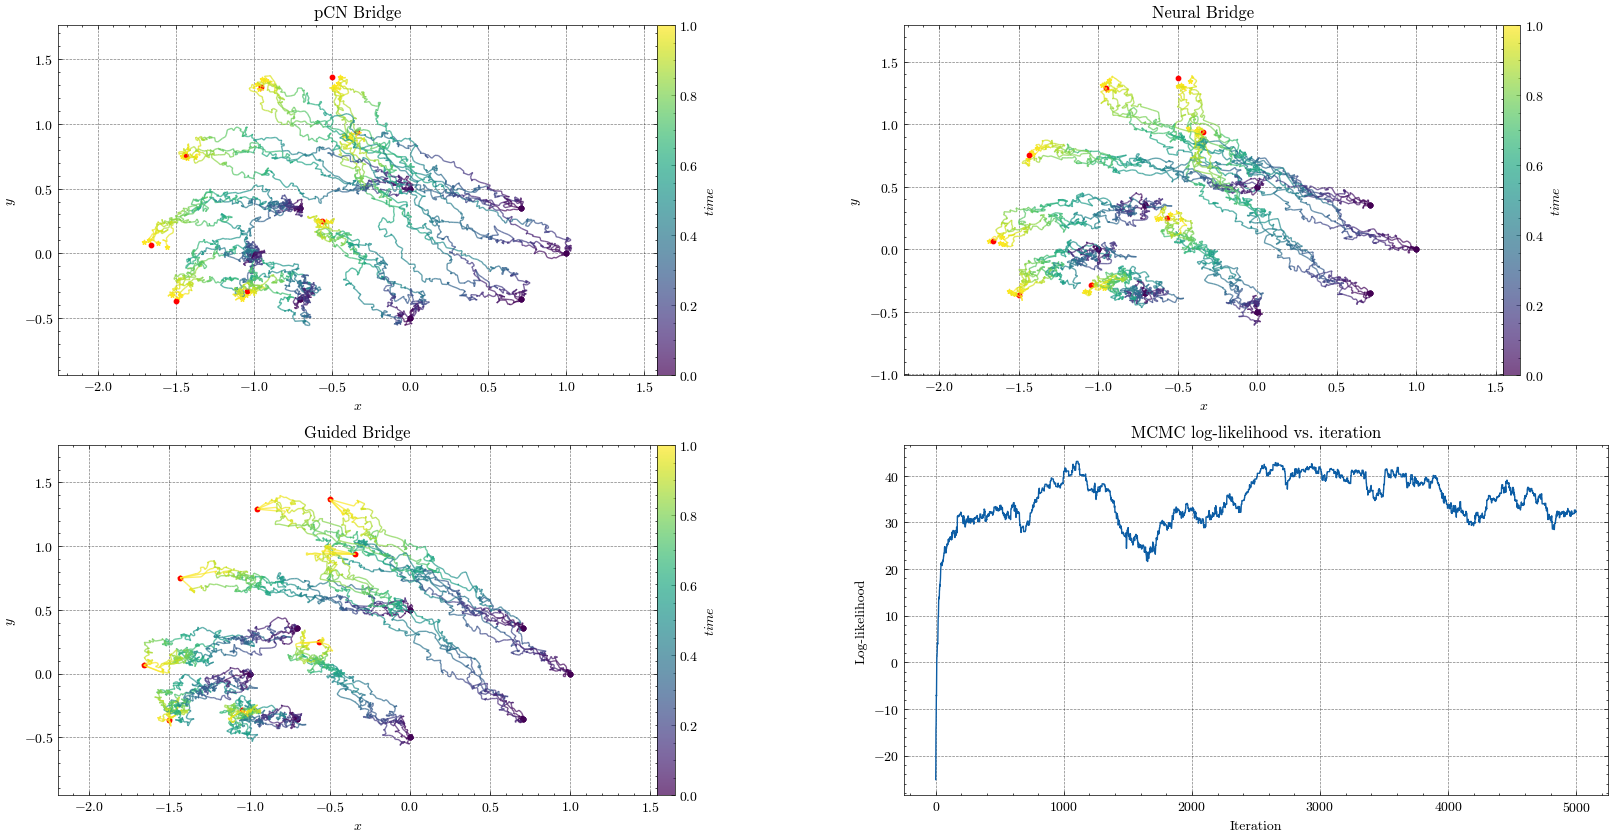

In [14]:
fig, ax = plt.subplots(2, 2, figsize=(20, 10))
plot_landmark_sample_path(pCN_result.path, m_landmarks, ax=ax[0, 0], cmap="viridis", title="pCN Bridge", scatter_size=10)
ax[0, 0].scatter(v.reshape(-1, 2)[:, 0], v.reshape(-1, 2)[:, 1], s=10, label="v", color='r')
plot_landmark_sample_path(X_diamond_path, m_landmarks, ax=ax[0, 1], cmap="viridis", title="Neural Bridge", scatter_size=10)
ax[0, 1].scatter(v.reshape(-1, 2)[:, 0], v.reshape(-1, 2)[:, 1], s=10, label="v", color='r')

plot_landmark_sample_path(X_circ_path[:4], m_landmarks, ax=ax[1, 0], cmap="viridis", title="Guided Bridge", scatter_size=10)
ax[1, 0].scatter(v.reshape(-1, 2)[:, 0], v.reshape(-1, 2)[:, 1], s=10, label="v", color='r')

ax[1, 1].plot(jnp.mean(pCN_result.log_lls, axis=1))
ax[1, 1].set_title("MCMC log-likelihood vs. iteration")
ax[1, 1].set_xlabel("Iteration")
ax[1, 1].set_ylabel("Log-likelihood")

In [14]:
sm_train_config = {
    "save_name": "landmarks_circle_1e-1alpha_5e-1sigma",
    "seed": seed,
    "learning_rate": 1e-4,
    "batch_size": 16,
    "n_iters": 1000,
    "n_epochs": 10,
    "ema_decay": 0.995,
    "optimizer": "adam",
    "clip_norm": None,
    "warmup_steps": 1000
}

In [15]:
neural_net = MLP(
    out_dim=dim, 
    hidden_dims=(32, 32, 32, 32),
    norm="batch",
    t_emb_dim=32,
    t_emb_max_period=200.0,
    t_emb_scaling=100.0
)
sm_reverse_bridge = scorematching.ScoreMatchingReversedBridge(ori_proc, neural_net, sm_train_config)
sm_reverse_bridge.initialize_path_solver(wiener_proc)
losses = sm_reverse_bridge.train_reversed_bridge(u=u, v=v, mode="pretrained")

/opt/homebrew/Caskroom/miniconda/base/envs/neuralbridge/lib/python3.11/site-packages/orbax/checkpoint/type_handlers.py:1386: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(
INFO:root:Checkpoint loaded from /Users/vbd402/Documents/Projects/neuralbridge/assets/ckpts/sm_backward/landmarks_circle_1e-1alpha_5e-1sigma
INFO:root:Loading pretrained model from the last epoch


In [16]:
reversed_bridge = sm_reverse_bridge.build_reversed_bridge()
reversed_bridge_solver = Euler(reversed_bridge, wiener_proc)
reversed_bridge_path = reversed_bridge_solver.solve(x0=v, rng_key=jax.random.PRNGKey(seed), batch_size=16, enforce_end_point=u)

Text(0.5, 0.98, 'Landmark model, guided by standard brownian process')

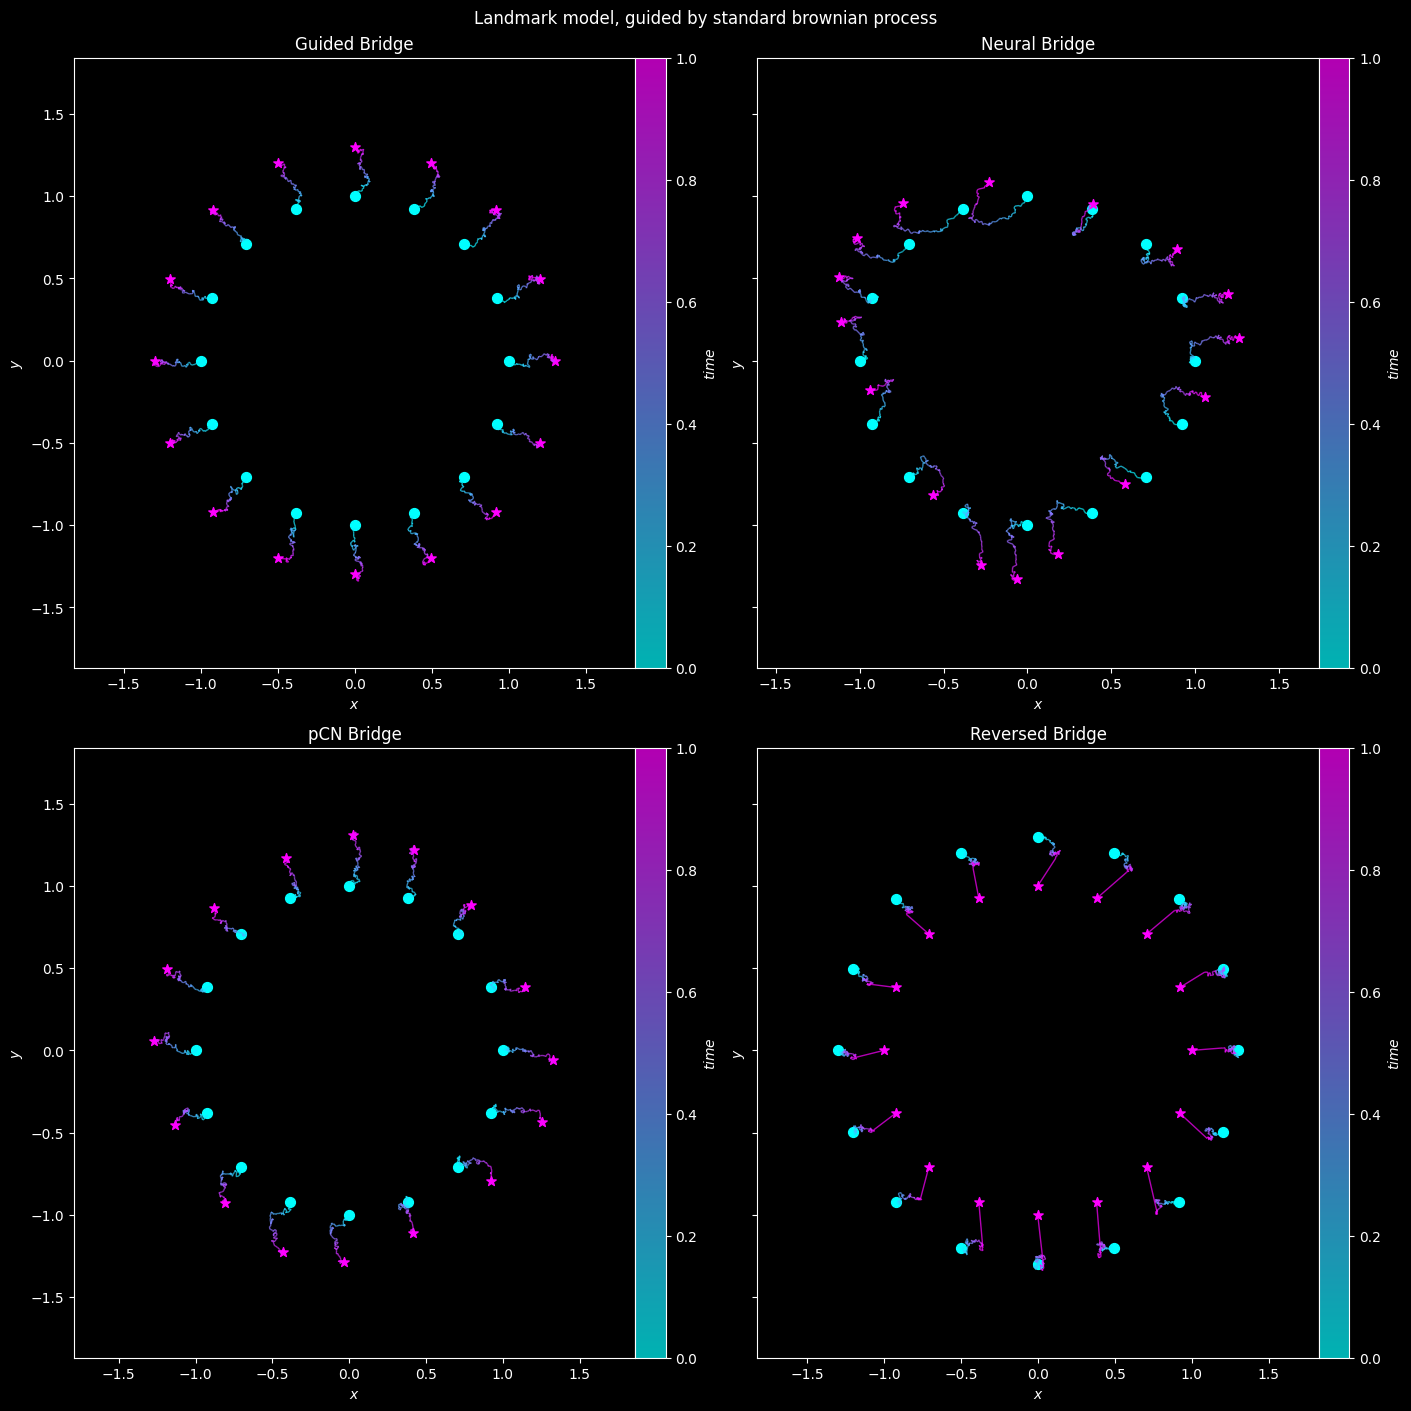

In [17]:
fig, ax = plt.subplots(2, 2, figsize=(14, 14), layout="constrained", sharey=True)
plot_landmark_sample_path(guided_path[1], m_landmarks, ax=ax[0, 0], cmap="cool", title="Guided Bridge")
plot_landmark_sample_path(neural_bridge_path[1], m_landmarks, ax=ax[0, 1], cmap="cool", title="Neural Bridge")
plot_landmark_sample_path(pCN_result.path_X[1], m_landmarks, ax=ax[1, 0], cmap="cool", title="pCN Bridge")
plot_landmark_sample_path(reversed_bridge_path[1], m_landmarks, ax=ax[1, 1], cmap="cool", title="Reversed Bridge")
fig.suptitle("Landmark model, guided by standard brownian process")